This example is available as a jupyter notebook [here](https://github.com/SimiPixel/x_xy_v2/blob/main/docs/notebooks/knee_joint_translational_dof.ipynb).

And on Google Colab [here](https://colab.research.google.com/github/SimiPixel/x_xy_v2/blob/main/docs/notebooks/knee_joint_translational_dof.ipynb)

Setup the environment if this is executed on Google Colab.

*Make sure to change the runtime type to `GPU`. To do this go to `Runtime` -> `Change runtime type` -> `GPU`*

Otherwise, rendering won't work in Google Colab.

In [ ]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.system("pip install --quiet 'x_xy[muj] @ git+https://github.com/SimiPixel/x_xy_v2'")
    os.system("pip install --quiet mediapy")
    os.system("pip install --quiet matplotlib")
    os.system("pip install --quiet dm-haiku")

In [8]:
import x_xy
# automatically detects colab or not
x_xy.utils.setup_colab_env()

import jax
import jax.numpy as jnp
import haiku as hk
import mediapy as media
import tree_utils

## Registering a Knee Joint Type

In [3]:
MAX_TRANSLATION = 0.1
ROM_MIN_RAD = 0.0
ROM_MAX_RAD = jnp.pi

def build_mlp_knee(key: jax.random.PRNGKey = jax.random.PRNGKey(1)):

    @hk.without_apply_rng
    @hk.transform
    def mlp(x):
        net = hk.nets.MLP([10, 10, 2], activation=jnp.tanh, w_init=hk.initializers.RandomNormal())
        # normalize the x input; [0, 1]
        x = (x + ROM_MIN_RAD) / (ROM_MAX_RAD - ROM_MIN_RAD)
        # center the x input; [-0.5, 0.5]
        x = (x - 0.5)
        return net(x)
    
    example_q = jnp.zeros((1,))
    params = mlp.init(key, example_q)

    def forward(params, q: jax.Array):
        return jax.nn.sigmoid(mlp.apply(params, q)) * MAX_TRANSLATION

    return params, forward

def _knee_init_joint_params(key):
    return build_mlp_knee(key)[0]


def transform_fn_knee(q: jax.Array, params: jax.Array) -> x_xy.Transform:
    forward = build_mlp_knee()[1]
    pos = jnp.concatenate((forward(params, q), jnp.array([0.0])))
    axis = jnp.array([0, 0, 1.0])
    rot = x_xy.maths.quat_rot_axis(axis, jnp.squeeze(q))
    return x_xy.Transform(pos, rot)


def draw_fn_knee(config: x_xy.RCMG_Config, key_t, key_value, dt, params):
    qs = x_xy.algorithms.jcalc._draw_rxyz(config, key_t, key_value, dt, params)
    # rom constraints
    return (qs / (2 * jnp.pi) + 0.5) * (ROM_MAX_RAD - ROM_MIN_RAD) + ROM_MIN_RAD

x_xy.register_new_joint_type("knee", x_xy.JointModel(transform_fn_knee, rcmg_draw_fn=draw_fn_knee, init_joint_params=_knee_init_joint_params), 1, 0)

In [4]:
HIP_REVOLUTE_JOINT = True

xml_str = f"""
<x_xy>
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <geom type="xyz" dim="0.15"/>
        <body name="_femur" joint="py" euler="90 90 0" pos="0.5 0.5 0.8">
            <geom type="xyz" dim="0.1"/>
            <body name="femur" joint="{"rz" if HIP_REVOLUTE_JOINT else "frozen"}">
                <geom type="xyz" dim="0.1"/>
                <geom type="capsule" mass="10" euler="0 90 0" pos="0.2 0 0" dim="0.05 0.4"/>
                <body name="imu1" joint="frozen" pos="0.2 0 0.06">
                    <geom type="xyz" dim="0.05"/>
                    <geom type="box" mass="0" dim="0.05 0.05 0.02" color="orange"/>
                </body>
                <body name="tibia" joint="knee" pos="0.4 0 0">
                    <geom type="xyz" dim="0.1"/>
                    <geom type="capsule" mass="10" euler="0 90 0" pos="0.2 0 0" dim="0.04 0.4"/>
                    <body name="imu2" joint="frozen" pos="0.2 0 0.06">
                        <geom type="xyz" dim="0.05"/>
                        <geom type="box" mass="0" dim="0.05 0.05 0.02" color="orange"/>
                    </body>
                    <geom type="box" mass="5.0" pos="0.45 -.1 0" dim="0.025 0.2 0.05"/>
                </body>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

sys = x_xy.load_sys_from_str(xml_str)

In [9]:
def finalize_fn(key, qs, xs: x_xy.Transform, sys: x_xy.System):
    X = {}
    for imu in ["imu1", "imu2"]:
        xs_imu = xs.take(sys.name_to_idx(imu), axis=1)
        X[imu] = {}
        X[imu]["pos"] = xs_imu.pos
        X[imu]["quat"] = xs_imu.rot
        X[imu]["imu"] = x_xy.imu(xs_imu, sys.gravity, sys.dt)
    
    params = tree_utils.tree_slice(sys.links.joint_params["knee"], sys.name_to_idx("tibia"))
    return qs, xs, X, params

data = x_xy.build_generator(sys, x_xy.RCMG_Config(t_min=0.1, t_max=0.75, T=30), finalize_fn=finalize_fn, randomize_joint_params=True, eager=True, aslist=True, seed=1, sizes=32)

eager data generation: 1it [00:07,  7.13s/it]


In [10]:
idx = 5
qs, xs, X, params = data[idx]

Text(0, 0.5, 'y translation [cm]')

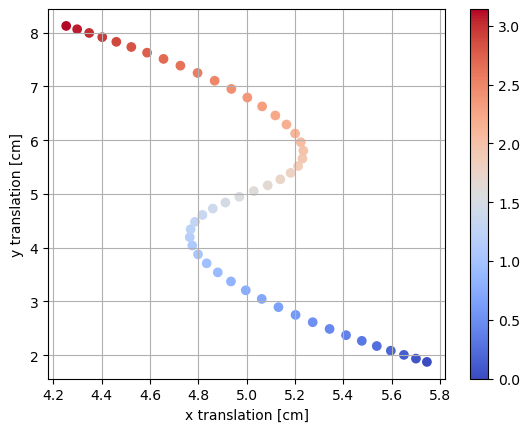

In [11]:
import matplotlib.pyplot as plt


phi = jnp.linspace(0.0, jnp.pi)[:, None]
# meter -> centimeter
trans_x, trans_y = jax.vmap(lambda arr: build_mlp_knee()[1](params, arr))(phi).T * 100
plt.scatter(trans_x, trans_y, c=phi, cmap="coolwarm")
plt.colorbar()
plt.grid()
plt.xlabel("x translation [cm]")
plt.ylabel("y translation [cm]")


In [13]:
media.show_video(x_xy.render(sys, [xs[i] for i in range(0, xs.shape(), 4)], camera="target", width=1280, height=720), fps=25)

Rendering frames..: 100%|██████████| 750/750 [00:05<00:00, 138.38it/s]
